In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt

# Preprocesamiento de imágenes con una muestra menor
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% para validación
)

test_datagen =  ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% para validación
)

# Generadores de datos con menos muestras para pruebas rápidas
train_generator = train_datagen.flow_from_directory(
    'train',
    classes = ["Benign", "Malignant"],
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
)

test_generator = test_datagen.flow_from_directory(
    'test',
    classes = ["Benign", "Malignant"],
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary'
)


Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adagrad, Adam, RMSprop

# Definir listas de hiperparámetros para probar
filters = [16, 32, 64, 128]
dropouts = [0.25, 0.5]
dense_units = [32, 64, 128]  # Añadido 128 para más combinaciones
optimizers = ["Adagrad", "Adam", "RMSprop"]
activation_functions = ['relu', 'tanh']  # Añadido 'tanh' para más combinaciones

# Criterios de parada
target_val_accuracy = 0.80
target_val_loss = 0.30

# Bucle sobre combinaciones de hiperparámetros
for filter1 in filters:
    for filter2 in filters:
        for filter3 in filters:
            for dropout1 in dropouts:
                for dropout2 in dropouts:
                    for dense_unit in dense_units:
                        for optimizer in optimizers:
                            for activation_function in activation_functions:
                                # Definir el modelo
                                model = Sequential()
                                model.add(Conv2D(filter1, (3, 3), activation=activation_function, input_shape=(224, 224, 3)))
                                model.add(MaxPooling2D(2, 2))
                                model.add(Conv2D(filter2, (3, 3), activation=activation_function))
                                model.add(MaxPooling2D(2, 2))
                                model.add(Conv2D(filter3, (3, 3), activation=activation_function))
                                model.add(MaxPooling2D(2, 2))
                                model.add(Dropout(dropout1))
                                model.add(Flatten())
                                model.add(Dense(dense_unit, activation=activation_function))
                                model.add(Dropout(dropout2))
                                model.add(Dense(1, activation='sigmoid'))

                                # Compilar el modelo
                                if optimizer == "Adagrad":
                                    opt = Adagrad()
                                elif optimizer == "Adam":
                                    opt = Adam()
                                elif optimizer == "RMSprop":
                                    opt = RMSprop()

                                model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

                                # Definir los callbacks
                                checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
                                earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

                                # Entrenar el modelo
                                history = model.fit(
                                    train_generator,
                                    epochs=7,
                                    steps_per_epoch=32,
                                    validation_data=test_generator,
                                    validation_steps=32,
                                    callbacks=[checkpoint, earlystop]
                                )

                                # Evaluar los resultados
                                val_accuracy = max(history.history['val_accuracy'])
                                val_loss = min(history.history['val_loss'])

                                print(f"Filters: {filter1}, {filter2}, {filter3} - Dropouts: {dropout1}, {dropout2} - Dense: {dense_unit} - Optimizer: {optimizer} - Activation: {activation_function} - Val_Acc: {val_accuracy} - Val_Loss: {val_loss}")

                                # Verificar si se alcanzaron los criterios deseados
                                if val_accuracy >= target_val_accuracy and val_loss <= target_val_loss:
                                    print("Criterios alcanzados. Deteniendo búsqueda.")
                                    break
                            else:
                                continue
                            break
                        else:
                            continue
                        break
                    else:
                        continue
                    break
                else:
                    continue
                break
            else:
                continue
            break
        else:
            continue
        break


Epoch 1/7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4306 - loss: 0.6962
Epoch 1: val_accuracy improved from -inf to 0.51172, saving model to model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.4331 - loss: 0.6961 - val_accuracy: 0.5117 - val_loss: 0.6911
Epoch 2/7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5951 - loss: 0.6854
Epoch 2: val_accuracy did not improve from 0.51172
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.5942 - loss: 0.6854 - val_accuracy: 0.5117 - val_loss: 0.6894
Epoch 3/7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5710 - loss: 0.6713
Epoch 3: val_accuracy did not improve from 0.51172
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.5700 - loss: 0.6717 - val_accuracy: 0.4883 - val_loss: 0.6930
Epoch 4/7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5503 - loss: 0.6824
Epoch 4: val_accuracy did not improve from 0.51172
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.5510 - loss: 0.6822 - 

KeyboardInterrupt: 

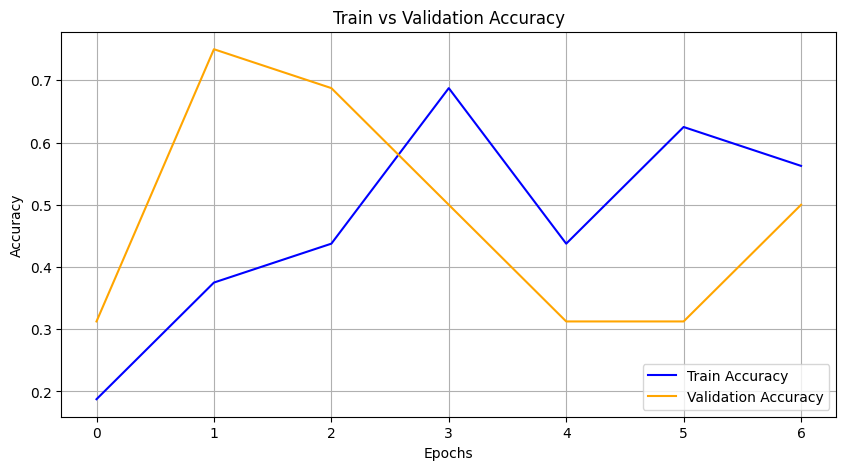

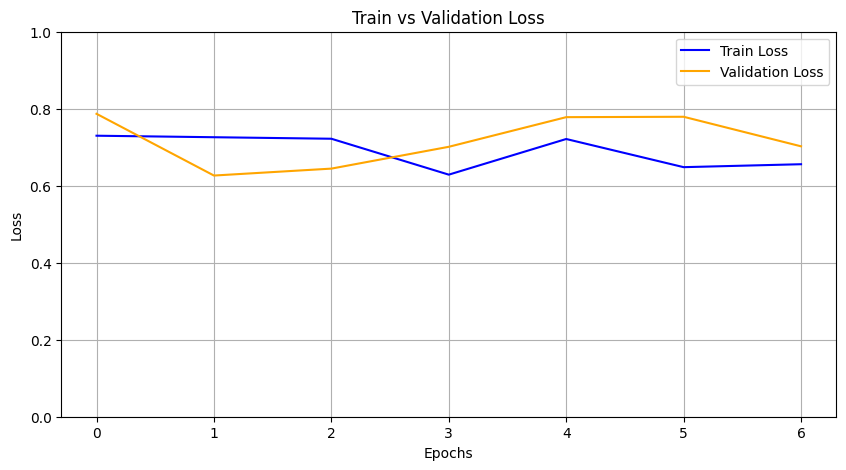

In [25]:

# Graficar resultados (accuracy y loss)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Gráfica de Precisión
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, acc, label='Train Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Gráfica de Pérdida
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, loss, label='Train Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step


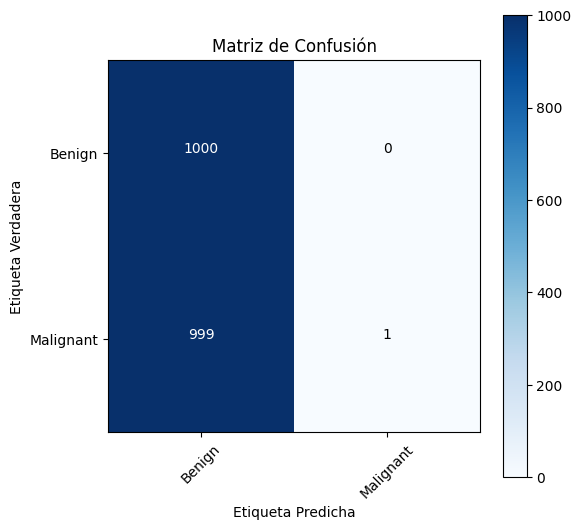

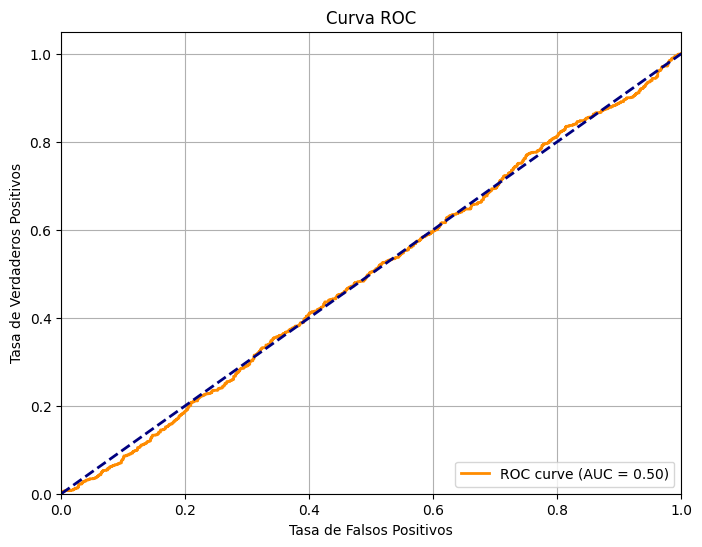

In [26]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Obtener las predicciones del modelo
y_pred = model.predict(test_generator)
y_pred_class = np.where(y_pred > 0.5, 1, 0)

# Obtener las etiquetas verdaderas del generador de test
y_true = test_generator.classes

# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred_class)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
plt.yticks(tick_marks, ['Benign', 'Malignant'])

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()